<a href="https://colab.research.google.com/github/Shreyas0786/Image-Detection-CNN/blob/main/Image_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert MNIST image files into Tensor of 4-Dimensions (# of images Height, Width Color Channel)

transform = transforms.ToTensor()

In [3]:
# Train Data
train_data = datasets.MNIST(root='/cnn.data', train = True, download = True, transform = transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 160728149.83it/s]

Extracting /cnn.data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn.data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 117379548.28it/s]


Extracting /cnn.data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn.data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 197591251.58it/s]

Extracting /cnn.data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn.data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23007884.99it/s]


Extracting /cnn.data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn.data/MNIST/raw



In [4]:
# Test Data

test_data = datasets.MNIST(root='/cnn.data', train = False, download = True, transform = transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn.data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn.data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Create a small batch size for images (10)

train_loader = DataLoader(train_data, batch_size = 10, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle=False)

In [8]:
# Model Class

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 Kernal and stride 2
    # Seond Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 Kernal and stride 2

    # Review to flatten it out

    X = X.view(-1, 16*5*5) # Negative 1 so that we can vary the batch size

    # Fully Connected Layers

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)


In [9]:
# Create an Instance for our model
torch.manual_seed(41)
model = ConvolutionalNetwork()

In [10]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
# Loss Function Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # Smaller the learning rate the longer it's going to take for training.

In [12]:
import time
start_time = time.time()

# Create Variables to Track Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For Loops of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train

  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from training set
    loss = criterion(y_pred, y_train) # Compare our predictions to the correct answers in y_train

    predicted = torch.max(y_pred.data, 1) [1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # How many we got correct from this batch. True = 1, False = 0, sum those up.
    trn_corr += batch_corr # keep track as we go along in training.


    # Update our Parameters

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0:
      print (f'Epoch: {i}  Batch: {b}  Loss:{loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  print(train_losses)
  # Test
  with torch.no_grad(): # No gradient so we don't update our weights and biases with the test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      prediction = torch.max(y_val.data, 1) [1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # True = 1 , False = 0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print (f'Training Took: {total/60} minutes!')
temp_losses = train_losses

Epoch: 0  Batch: 600  Loss:0.1599934995174408
Epoch: 0  Batch: 1200  Loss:0.18979528546333313
Epoch: 0  Batch: 1800  Loss:0.5580862760543823
Epoch: 0  Batch: 2400  Loss:0.2070152312517166
Epoch: 0  Batch: 3000  Loss:0.006888664327561855
Epoch: 0  Batch: 3600  Loss:0.33112621307373047
Epoch: 0  Batch: 4200  Loss:0.004664934705942869
Epoch: 0  Batch: 4800  Loss:0.0020317500457167625
Epoch: 0  Batch: 5400  Loss:0.06558699160814285
Epoch: 0  Batch: 6000  Loss:0.000513441045768559
[tensor(0.0005, grad_fn=<NllLossBackward0>)]
Epoch: 1  Batch: 600  Loss:0.004773168824613094
Epoch: 1  Batch: 1200  Loss:0.30684694647789
Epoch: 1  Batch: 1800  Loss:0.0025840331800282
Epoch: 1  Batch: 2400  Loss:0.004851708188652992
Epoch: 1  Batch: 3000  Loss:0.05095291882753372
Epoch: 1  Batch: 3600  Loss:0.29904529452323914
Epoch: 1  Batch: 4200  Loss:0.020275484770536423
Epoch: 1  Batch: 4800  Loss:0.0018002415308728814
Epoch: 1  Batch: 5400  Loss:0.0003511425748001784
Epoch: 1  Batch: 6000  Loss:0.1681706607

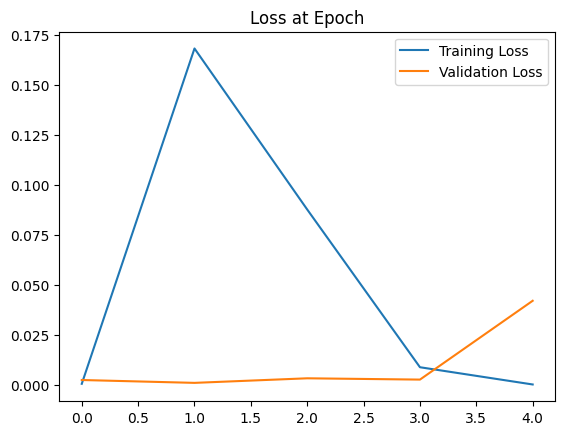

In [13]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()


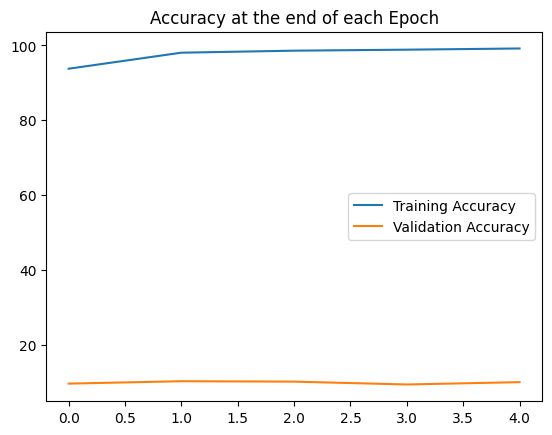

In [14]:
# Graph the accuracy at the end of each epoch

plt.plot ([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot ([t/100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [16]:
test_load_everything = DataLoader(test_data, batch_size = 10000, shuffle=False)

In [17]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [19]:
# How many did we get correct
correct.item()/len(test_data )*100

98.86

In [28]:
# Grab an Image
test_data[1996] # Tensor with an image in it... at the end, it shows the label


(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1137, 0.6863,
           0.9961, 0.6824, 0.3765, 0.0549, 

In [35]:
# Reshape it
test_data[1996][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1137, 0.6863, 0.9961, 0.6824,
         0.3765, 0.0549, 0.0000, 0.0000, 0.0000, 0.0000

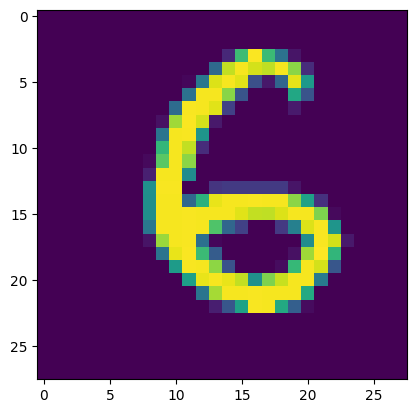

In [36]:
# Show the image
plt.imshow(test_data[1996][0].reshape(28,28))

In [37]:
# Pass the image through our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1996][0].view(1,1,28,28)) # Batch of 1, One Color Channel, 28x28 pixels


In [38]:
# Check the new prediction... get probabilities
new_prediction

tensor([[-1.4116e+01, -2.8977e+01, -3.3693e+01, -2.7752e+01, -2.3216e+01,
         -1.9426e+01, -7.1526e-07, -4.0049e+01, -2.0607e+01, -2.4891e+01]])

In [39]:
new_prediction.argmax()

tensor(6)